In [1]:
import os, sys
import warnings
warnings.filterwarnings("ignore")

import scanpy as sc
#sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import rcParams


In [2]:
path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/'
table_path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/results/tables/new/'
figure_path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/results/figures/new/'


In [3]:
path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/data/lung_organoid_all_original_filtered_022024.h5ad'
adata = sc.read_h5ad(path)
#adata.obs['treatment'] = ['DMSO' if 'DMSO' in x else 'RMC-113' for x in adata.obs.ID]
adata


AnnData object with n_obs × n_vars = 144685 × 62703
    obs: 'species', 'ID', 'gene_count', 'tscp_count', 'mread_count', 'run', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_total_counts', 'doublet_score', 'predicted_doublets', 'cell_type', 'leiden_r1', 'high_quality', 'viral_counts', 'is_viral_0', 'is_viral', 'viral_CPM', 'viral_log1p', 'tpi', 'infected', 'bulk_labels', 'M', 'N', 'ORF10', 'ORF1ab', 'ORF3a', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'S', 'E', 'treated'
    var: 'gene_id', 'gene_name', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts'

In [5]:
filtered = adata[adata.obs.high_quality == 'True'].copy()
filtered = filtered[filtered.obs.ID.isin(['4h infected DMSO', '4h infected RMC113', '4h uninfected DMSO', '4h uninfected RMC113',
                                          '24h_infected_DMSO', '24h_infected_RMC113', 
                                          '24h uninfected RMC-113 (5uM)', '24h uninfected DMSO', 
                                          #'24h infected RMC113', '24h infected DMSO',
                                         ])].copy()
filtered.obs['newID'] = filtered.obs.tpi.astype('str')+'h_'+filtered.obs.infected.map({'False': 'uninfected', 'True': 'infected'}).astype('str')+'_'+filtered.obs.treated.astype('str')
filtered.obs['newID'] = filtered.obs['newID'].astype('category')
#filtered.obs['newID'].cat.categories

filtered.layers['counts'] = filtered.X.copy()

sc.pp.normalize_total(filtered, target_sum=1e6)
sc.pp.log1p(filtered)

# Save raw expression values before variable gene subset
filtered.raw = filtered.copy()
filtered.layers['raw'] = filtered.X.copy()


In [6]:
filtered.obs['bystanders'] = 'low'
filtered.obs.loc[filtered.obs.viral_counts==0, 'bystanders'] = 'zero'
filtered.obs.loc[filtered.obs.viral_counts==1, 'bystanders'] = '1'
filtered.obs.loc[filtered.obs.viral_counts==2, 'bystanders'] = '2'
filtered.obs.loc[filtered.obs.viral_counts==3, 'bystanders'] = '3'
filtered.obs.loc[filtered.obs.viral_counts>3, 'bystanders'] = 'high'

pd.crosstab(filtered.obs['bystanders'], filtered.obs.newID).T



bystanders,1,2,3,high,zero
newID,,,,,
24h_infected_DMSO,1864,571,214,421,5571
24h_infected_RMC-113,1076,221,66,115,6388
24h_uninfected_DMSO,0,0,0,0,1369
24h_uninfected_RMC-113,0,0,0,0,1833
4h_infected_DMSO,27,8,8,19,73
4h_infected_RMC-113,60,28,19,42,95
4h_uninfected_DMSO,24,8,1,2,218
4h_uninfected_RMC-113,38,1,1,2,289


In [7]:
filtered.obs['bystanders'] = 'low'
filtered.obs.loc[filtered.obs.viral_counts==0, 'bystanders'] = 'zero'
filtered.obs.loc[filtered.obs.viral_counts>3, 'bystanders'] = 'high'

pd.crosstab(filtered.obs['bystanders'], filtered.obs.newID).T


bystanders,high,low,zero
newID,,,
24h_infected_DMSO,421,2649,5571
24h_infected_RMC-113,115,1363,6388
24h_uninfected_DMSO,0,0,1369
24h_uninfected_RMC-113,0,0,1833
4h_infected_DMSO,19,43,73
4h_infected_RMC-113,42,107,95
4h_uninfected_DMSO,2,33,218
4h_uninfected_RMC-113,2,40,289


In [10]:
ct_map = {'AT1': 'AT1-like cells',
             'AT2': 'AT2-like cells',
             'Basal':'Basal-like cells',
              'NFGR-HOPX-CEACAM6+': 'NGFR-HOPX-CEACAM6+',
             }
filtered.obs['cell type'] = filtered.obs.cell_type.map(ct_map).astype('category')

filtered.obs['cell type'] = filtered.obs['cell type'].cat.reorder_categories(['AT2-like cells', 'AT1-like cells', 'NGFR-HOPX-CEACAM6+', 'Basal-like cells'], ordered=True)

In [ ]:
def sample_and_compare(adata1, adata2, n_sample=0, n=100, log1p=2):
    
    from random import sample
    if n_sample == 0: n_sample = min(adata1.shape[0], adata2.shape[0])

    var_names = [x for x in adata1.var_names if x in adata2.var_names]
    results = pd.DataFrame(np.zeros((n, len(var_names)), np.float64),
                           columns=var_names,
                          )

    for x in np.arange(n):
        # w/o replacement
        samplelist1 = sample(list(adata1.obs_names), n_sample)
        samplelist2 = sample(list(adata2.obs_names), n_sample)
        
        adata_1 = adata1[np.in1d(adata1.obs.index, samplelist1),:]
        adata_2 = adata2[np.in1d(adata2.obs.index, samplelist2),:]
        
        # Compute averages
        avg1 = adata_1.X.mean(axis=0)
        avg2 = adata_2.X.mean(axis=0)
        
        # Compute log2 fold changes
        if log1p is False: log2_fc = np.log2(avg1 + 1) - np.log2(avg2 + 1)
        elif log1p not in (True, 2): log2_fc = (avg1 - avg2) / np.log2(log1p)
        else: log2_fc = avg1 - avg2
        
        results.loc[x] = log2_fc

    return results


def boxplot_from_log2FC(log2FCs, title='all_cell_types', xlim=3, cbar_label= 'log2 fold change \n(VHCs vs bystanders)\n24h_infected_DMSO', height=5, aspect = 0.5, vmin=-1.5, vmax = 1.5):
    fig, ax = plt.subplots(figsize=[height*aspect, height])
    cmap = sns.diverging_palette(245, 5, as_cmap=True)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    palette = [cmap(norm(x)) for x in np.clip(log2FCs.median(axis=0), vmin, vmax)]
    sns.boxplot(data=log2FCs, orient="h", ax=ax, palette=palette)
    ax.set_title(title)
    ax.set_xlim(xlim*-1, xlim)
    ax.tick_params(labelsize=12)
    #ax.set_xticks([str(x) for x in np.linspace(vmin,vmax,1)])
    for x in [-1, 0, 1]:
        ax.axvline(x, c='black', ls='-.', lw=0.5, zorder=0.5)
    
    ax_cb = fig.add_axes([0.15, 0.04, 0.65, 0.02])
    cbar = mpl.colorbar.ColorbarBase(ax_cb, norm=norm, cmap=cmap, orientation='horizontal')
    cbar.set_ticks(list(range(vmin, vmax+1, 1)))
    cbar.set_ticklabels([str(x) for x in list(range(vmin, vmax+1, 1))])
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(cbar_label)

    return fig, ax
#fig.tight_layout()
#data_path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/'
#fig.savefig(data_path + 'results/figures/24h_infected_RMC113_box_DEGs_VHCs_autophagy_more_than_3vRNAs.pdf', bbox_inches='tight')

In [ ]:
cts = ['AT2']
marker_genes = ["MTOR", ## "mTORC1", 
                "ULK1", "ATG13",
                "RB1CC1", ## "FIP200",
                "BECN1", 
                #"ATG14", 
#                   "PIK3C3", ## "PIK3C3/VPS34", 
                'ATG7', 'ATG8', 'ATG10', 'ATG12', 'ATG16L1', 
                'MAP1LC3B', 'SQSTM1', 
                'WDFY3','NBR1', 'TAX1BP1',
                "LAMP2", "TECPR1",
                "ATG14", "STX17", "VAMP8",
                "SNAP29", "RAB7A",  
                "PLEKHM1", "GABARAP",
                "VPS11", "VPS16", "VPS18",
                "VPS33A", "VPS33B", ## "Vps33", 
                   "VPS39", "VPS41",
                ]
genes = [x.upper() for x in marker_genes if x.upper() in filtered.var_names]

newdata = filtered[filtered.obs.cell_type.isin(cts)].copy()


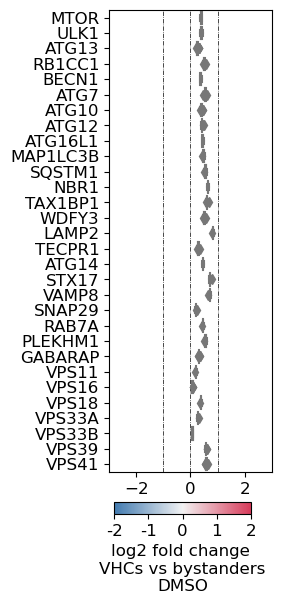

In [44]:
from matplotlib import rcParams
rcParams['font.size']=12

cond='bystanders'
samp='DMSO'
sample1 = '24h_infected_DMSO'
sample2 = '24h_infected_DMSO'
n_sample = 0

adata_1 = newdata[newdata.obs.newID.str.startswith(sample1)].copy()
adata_1 = adata_1[:,genes].copy()


adata_2 = newdata[newdata.obs.newID.str.startswith(sample2)].copy()
adata_2 = adata_2[:,genes].copy()


adata1 = adata_1[adata_1.obs.bystanders.isin(['high', 'low'])]
adata2 = adata_2[adata_2.obs.bystanders == 'zero']


log2fc_temp = sample_and_compare(adata1, adata2, n_sample=n_sample, n=100, log1p=2)
fig, ax = boxplot_from_log2FC(log2fc_temp, xlim=3, vmin=-2, vmax=2,
                              title='',
                              height=6, aspect = 0.35, 
                              cbar_label= f'log2 fold change \nVHCs vs {cond}\n{samp}',
                             )
plt.show()
#fig.savefig(figure_path + f'boxplot_autophagy_genes_{ct}_VHCs_vs_{cond}_{samp}_{n_sample}_new_allVHC.svg', 
            bbox_inches='tight')



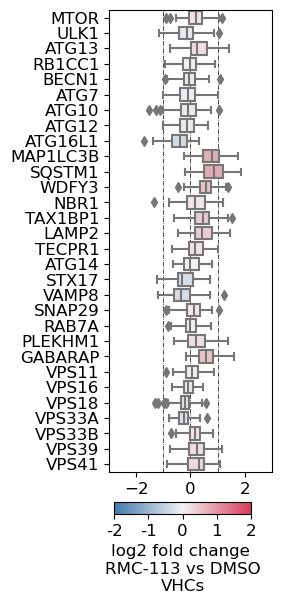

In [114]:
from matplotlib import rcParams
rcParams['font.size']=12

cond='RMC-113 vs DMSO'
samp='VHCs'
sample1 = '24h_infected_RMC-113'
sample2 = '24h_infected_DMSO'
n_sample = 50

adata_1 = newdata[newdata.obs.newID.str.startswith(sample1)].copy()
adata_1 = adata_1[:,genes].copy()


adata_2 = newdata[newdata.obs.newID.str.startswith(sample2)].copy()
adata_2 = adata_2[:,genes].copy()


#adata1 = adata_1[(adata_1.obs.viral_counts == 0)] #2005
#adata2 = adata_2[(adata_2.obs.viral_counts == 0)] #1404
adata1 = adata_1[(adata_1.obs.viral_counts>1)] #56
adata2 = adata_2[(adata_2.obs.viral_counts>1)] #258


log2fc_temp = sample_and_compare(adata1, adata2, n_sample=n_sample, n=100, log1p=2)
fig, ax = boxplot_from_log2FC(log2fc_temp, xlim=3, vmin=-2, vmax=2,
                              title='',
                              height=6, aspect = 0.35, 
                              cbar_label= f'log2 fold change \n{cond}\n{samp}',
                             )
plt.show()
#fig.savefig(figure_path + f'boxplot_autophagy_genes_{ct}_VHCs_vs_{cond}_{samp}_{n_sample}_new_vRNA_2.svg', bbox_inches='tight')



In [115]:
filtered.obs

,species,ID,gene_count,tscp_count,mread_count,run,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,...,ORF6,ORF7a,ORF7b,ORF8,S,E,treated,newID,bystanders,cell type
01_01_06-run1-run1,GRCh38,24h uninfected DMSO,4722,12330,13660,run1,4722,12330.0,1422.0,11.532846,...,0.0,0.0,0.0,0.0,0.0,0.0,DMSO,24h_uninfected_DMSO,zero,Basal-like cells
01_01_62-run1-run1,GRCh38,24h uninfected DMSO,2791,6445,7124,run1,2791,6445.0,703.0,10.907681,...,0.0,0.0,0.0,0.0,0.0,0.0,DMSO,24h_uninfected_DMSO,zero,Basal-like cells
01_01_86-run1-run1,GRCh38,24h uninfected DMSO,3044,7478,8299,run1,3044,7478.0,248.0,3.316395,...,0.0,0.0,0.0,0.0,0.0,0.0,DMSO,24h_uninfected_DMSO,zero,Basal-like cells
01_02_36-run1-run1,GRCh38,24h uninfected DMSO,6292,28805,31927,run1,6292,28805.0,1320.0,4.582538,...,0.0,0.0,0.0,0.0,0.0,0.0,DMSO,24h_uninfected_DMSO,zero,AT1-like cells
01_03_05-run1-run1,GRCh38,24h uninfected DMSO,3499,10248,11342,run1,3499,10248.0,929.0,9.065184,...,0.0,0.0,0.0,0.0,0.0,0.0,DMSO,24h_uninfected_DMSO,zero,Basal-like cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42_95_24__s8-run3,hg38,24h_infected_RMC113,1284,2937,3345,run3,1284,2937.0,589.0,20.054478,...,0.0,0.0,0.0,0.0,0.0,0.0,RMC-113,24h_infected_RMC-113,zero,AT2-like cells
42_95_36__s8-run3,hg38,24h_infected_RMC113,1790,2706,3101,run3,1790,2706.0,92.0,3.399852,...,0.0,0.0,0.0,0.0,0.0,0.0,RMC-113,24h_infected_RMC-113,zero,Basal-like cells
42_95_43__s8-run3,hg38,24h_infected_RMC113,3597,7859,9014,run3,3597,7859.0,689.0,8.767018,...,0.0,0.0,0.0,0.0,0.0,0.0,RMC-113,24h_infected_RMC-113,zero,Basal-like cells
42_95_67__s8-run3,hg38,24h_infected_RMC113,3385,7589,8697,run3,3385,7589.0,494.0,6.509422,...,0.0,0.0,0.0,0.0,0.0,0.0,RMC-113,24h_infected_RMC-113,high,AT1-like cells


In [107]:
adata1

View of AnnData object with n_obs × n_vars = 2005 × 30
    obs: 'species', 'ID', 'gene_count', 'tscp_count', 'mread_count', 'run', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_total_counts', 'doublet_score', 'predicted_doublets', 'cell_type', 'leiden_r1', 'high_quality', 'viral_counts', 'is_viral_0', 'is_viral', 'viral_CPM', 'viral_log1p', 'tpi', 'infected', 'bulk_labels', 'M', 'N', 'ORF10', 'ORF1ab', 'ORF3a', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'S', 'E', 'treated', 'newID', 'bystanders', 'cell type'
    var: 'gene_id', 'gene_name', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'cell type_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'counts', '

In [77]:
adata2

View of AnnData object with n_obs × n_vars = 223 × 28
    obs: 'species', 'ID', 'gene_count', 'tscp_count', 'mread_count', 'run', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_total_counts', 'doublet_score', 'predicted_doublets', 'cell_type', 'leiden_r1', 'high_quality', 'viral_counts', 'is_viral_0', 'is_viral', 'viral_CPM', 'viral_log1p', 'tpi', 'infected', 'bulk_labels', 'M', 'N', 'ORF10', 'ORF1ab', 'ORF3a', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'S', 'E', 'treated', 'newID', 'bystanders', 'cell type', 'n_genes'
    var: 'gene_id', 'gene_name', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'cell_type_colors', 'newID_colors', 'cell type_colors'
    obsm: 'X_pca', 'X_umap'

In [78]:
adata1

View of AnnData object with n_obs × n_vars = 56 × 28
    obs: 'species', 'ID', 'gene_count', 'tscp_count', 'mread_count', 'run', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_total_counts', 'doublet_score', 'predicted_doublets', 'cell_type', 'leiden_r1', 'high_quality', 'viral_counts', 'is_viral_0', 'is_viral', 'viral_CPM', 'viral_log1p', 'tpi', 'infected', 'bulk_labels', 'M', 'N', 'ORF10', 'ORF1ab', 'ORF3a', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'S', 'E', 'treated', 'newID', 'bystanders', 'cell type', 'n_genes'
    var: 'gene_id', 'gene_name', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'cell_type_colors', 'newID_colors', 'cell type_colors'
    obsm: 'X_pca', 'X_umap',

In [15]:
[x for x in adata_ct.var_names if 'IG4' in x]

['FIG4', 'VSIG4', 'LIG4']

In [22]:
adata_ct.obs.tpi

01_03_36-run1-run1    24
01_06_57-run1-run1    24
01_07_01-run1-run1    24
01_07_22-run1-run1    24
01_13_28-run1-run1    24
                      ..
42_93_58__s8-run3     24
42_93_76__s8-run3     24
42_94_07__s8-run3     24
42_95_24__s8-run3     24
42_96_19__s8-run3     24
Name: tpi, Length: 5865, dtype: category
Categories (2, object): ['4', '24']

In [13]:
filtered

AnnData object with n_obs × n_vars = 20672 × 62703
    obs: 'species', 'ID', 'gene_count', 'tscp_count', 'mread_count', 'run', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_total_counts', 'doublet_score', 'predicted_doublets', 'cell_type', 'leiden_r1', 'high_quality', 'viral_counts', 'is_viral_0', 'is_viral', 'viral_CPM', 'viral_log1p', 'tpi', 'infected', 'bulk_labels', 'M', 'N', 'ORF10', 'ORF1ab', 'ORF3a', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'S', 'E', 'treated', 'newID', 'bystanders', 'cell type'
    var: 'gene_id', 'gene_name', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts', 'raw'

In [17]:
adata_ct = filtered[filtered.obs.cell_type.str.contains('AT2')].copy()
adata_tmp = adata_ct[adata_ct.obs.tpi.isin(['24'])].copy()
gene = 'TFEB'

df = adata_tmp.obs[['newID', 'cell_type']]
df[gene] = adata_tmp[:,gene].X.A
df.index.name = 'cellID'
df = df.reset_index()
df['ID'] = [' '.join(x.split('_')[1:]) for x in df.newID]
#df.ID = df.ID.replace('uninfected RMC-113 (5uM)', 'uninfected RMC113')
#df.ID = [x[3:] for x in df.ID]

df

,cellID,newID,cell_type,TFEB,ID
0,01_03_36-run1-run1,24h_uninfected_DMSO,AT2,0.0,uninfected DMSO
1,01_06_57-run1-run1,24h_uninfected_DMSO,AT2,0.0,uninfected DMSO
2,01_07_01-run1-run1,24h_uninfected_DMSO,AT2,0.0,uninfected DMSO
3,01_07_22-run1-run1,24h_uninfected_DMSO,AT2,0.0,uninfected DMSO
4,01_13_28-run1-run1,24h_uninfected_DMSO,AT2,0.0,uninfected DMSO
...,...,...,...,...,...
5703,42_93_58__s8-run3,24h_infected_RMC-113,AT2,0.0,infected RMC-113
5704,42_93_76__s8-run3,24h_infected_RMC-113,AT2,0.0,infected RMC-113
5705,42_94_07__s8-run3,24h_infected_RMC-113,AT2,0.0,infected RMC-113
5706,42_95_24__s8-run3,24h_infected_RMC-113,AT2,0.0,infected RMC-113


In [18]:
df.ID.unique()

array(['uninfected DMSO', 'uninfected RMC-113', 'infected DMSO',
       'infected RMC-113'], dtype=object)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


uninfected DMSO vs. uninfected RMC-113: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.435e-01 U_stat=1.549e+04
infected DMSO vs. infected RMC-113: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.677e-05 U_stat=3.719e+06
uninfected DMSO vs. infected DMSO: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.172e-01 U_stat=1.722e+05
uninfected DMSO vs. infected RMC-113: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.916e-01 U_stat=1.775e+05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


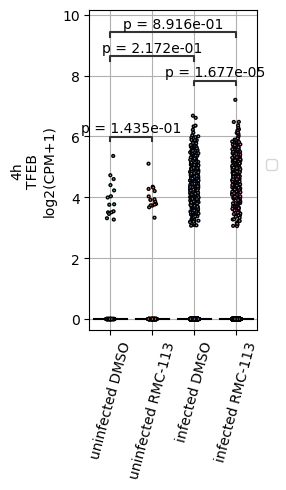

In [19]:
## plot cell abundance figure

import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu, ks_2samp

pairs = [
    ['infected DMSO', 'uninfected DMSO'],
    ['uninfected RMC-113', 'uninfected DMSO'],
    ['infected RMC-113', 'uninfected DMSO'],
    ['infected RMC-113', 'infected DMSO'],
]

order = ['uninfected DMSO', 'uninfected RMC-113', 'infected DMSO',
         'infected RMC-113', 
        ]

'''test value should be a StatTest instance or one of the following strings: 
t-test_ind, t-test_welch, t-test_paired, Mann-Whitney, Mann-Whitney-gt, 
Mann-Whitney-ls, Levene, Wilcoxon, Kruskal, Brunner-Munzel.'''

cmap = sns.color_palette('Set2', 4)

hue_plot_params = {'data': df.dropna(),
                   'x' : 'ID', 
                   'y' : gene, 
                   'order': order,
                   'zorder' : 8,
                   'boxprops': {'edgecolor':'none'}, 
                   'medianprops' : {'color':'black'},
                   'capprops' : {'color':'none'},
                   'palette' : cmap, 
                   'width' : 0.8, 
                   'showfliers': False}


fig, ax = plt.subplots(figsize=[3,5])

sns.boxplot(ax=ax, **hue_plot_params).legend(bbox_to_anchor=(1, 1))

empty_box=False
if empty_box:
    ## modify the lines
    for i,box in enumerate([p for p in ax.patches if not p.get_label()]): 
        color = box.get_facecolor()
        box.set_edgecolor(color)
        box.set_facecolor((0, 0, 0, 0))
        # iterate over whiskers and median lines
        for j in range(5*i,5*(i+1)):
            ax.lines[j].set_color(color)

            
sns.stripplot(data = df.dropna(), 
              x = 'ID', y = gene, zorder=10, order=order,
             palette=cmap,  s=2, ax=ax, edgecolor='black', linewidth=1, dodge=True).legend('')



# Add annotations
annotator = Annotator(ax, pairs, **hue_plot_params)
annotator.new_plot(ax, **hue_plot_params)
annotator.configure(test="Mann-Whitney", comparisons_correction="BH", 
                    text_format="full", verbose=True, show_test_name=False).apply_and_annotate()
#ann = annotator.configure(test="Mann-Whitney", comparisons_correction="BH", 
#                    text_format="full", verbose=True).get_annotations_text()
#ann = [f'p={x[11:]}' for x in ann]


# Add annotations
#annotator = Annotator(ax, pairs, **hue_plot_params)
#formatted_pvalues = [f"p={p}" for p in pvalues]
#annotator.set_custom_annotations(ann)
#annotator.annotate()


ax.legend(loc=(1.05, 0.5))
ax.set_ylabel(f'4h\n{gene}\nlog2(CPM+1)')
ax.set_xlabel(None)
labels = [x.get_text() for x in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=75)
ax.set_axisbelow(True)
ax.grid(True)


fig.tight_layout()
#plt.savefig(f'{figure_path}{gene}_expression_draft.svg')
plt.show()



In [168]:
adata_ct = filtered[filtered.obs.cell_type.str.contains('AT2')].copy()
adata_tmp = adata_ct[adata_ct.obs.ID.str.contains('24h')].copy()
gene = 'RAB7A'

df = adata_tmp.obs[['newID', 'cell_type']]
df[gene] = adata_tmp[:,gene].X.A
df.index.name = 'cellID'
df = df.reset_index()
df['ID'] = [x[4:].replace('_', ' ') for x in df.newID]
#df.ID = df.ID.replace('uninfected RMC-113 (5uM)', 'uninfected RMC113')
#df.ID = [x[3:] for x in df.ID]

#df

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uninfected DMSO vs. uninfected RMC-113: p=0.01065
infected DMSO vs. infected RMC-113: p=0.2857
uninfected DMSO vs. infected DMSO: p=4.847e-08
uninfected DMSO vs. infected RMC-113: p=2.215e-06


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


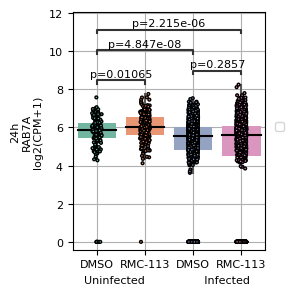

In [169]:
## plot cell abundance figure

import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu, ks_2samp
from matplotlib import rcParams
rcParams['font.size']=8

pairs = [
    ['uninfected RMC-113', 'uninfected DMSO'],
    ['infected RMC-113', 'infected DMSO'],
    ['infected DMSO', 'uninfected DMSO'],
    ['infected RMC-113', 'uninfected DMSO'],
]


## MAP1LC3B
#pvalues = [3.925e-03,
#           1.019e-02,
#           8.538e-06,
#           1.516e-03
#          ]

##SQSTM1
#pvalues = [3.718e-06,
#           2.791e-29,
#           8.572e-07,
#           4.632e-01]

##WDFY3
#pvalues = [9.833e-13,
#           2.064e-23,
#           7.928e-01,
#           1.124e-03]

##ATG14
#pvalues=[5.641e-03,
#         7.831e-01,
#         1.236e-14,
#         5.111e-14]

##PLEKHM1
#pvalues = [3.252e-02,
#           1.172e-03,
#           5.939e-18,
#           1.900e-12]

##RAB7A
pvalues = [1.065e-02,
           2.857e-01,
           4.847e-08,
           2.215e-06]


order = ['uninfected DMSO', 
         'uninfected RMC-113', 
         'infected DMSO', 
         'infected RMC-113', 
        ]
cmap = sns.color_palette('Set2', 4)

hue_plot_params = {'data': df.dropna(),
                   'x' : 'ID', 
                   'y' : gene, 
                   'order': order,
                   'zorder' : 8,
                   'boxprops': {'edgecolor':'none'}, 
                   'medianprops' : {'color':'black'},
                   'capprops' : {'color':'none'},
                   'palette' : cmap, 
                   'width' : 0.8, 
                   'showfliers': False}


fig, ax = plt.subplots(figsize=[3, 3])

sns.boxplot(ax=ax, **hue_plot_params).legend(bbox_to_anchor=(1, 1))

empty_box=False
if empty_box:
    ## modify the lines
    for i,box in enumerate([p for p in ax.patches if not p.get_label()]): 
        color = box.get_facecolor()
        box.set_edgecolor(color)
        box.set_facecolor((0, 0, 0, 0))
        # iterate over whiskers and median lines
        for j in range(5*i,5*(i+1)):
            ax.lines[j].set_color(color)

            
sns.stripplot(data = df.dropna(), 
              x = 'ID', y = gene, order=order, zorder=10,
             palette=cmap,  s=2, ax=ax, edgecolor='black', linewidth=1, dodge=True).legend('')


# Add annotations
annotator = Annotator(ax, pairs, **hue_plot_params)
formatted_pvalues = [f"p={p}" for p in pvalues]
annotator.set_custom_annotations(formatted_pvalues)
annotator.annotate()

ax.legend(loc=(1.05, 0.5))
ax.set_ylabel(f'24h\n{gene}\nlog2(CPM+1)', fontsize='medium')
labels = [x.get_text() for x in ax.get_xticklabels()]
ax.set_xticklabels([x.split()[1] for x in labels], rotation=0, fontsize='medium')
ax.set_xlabel('Uninfected                 Infected ', fontsize='medium')
ax.set_axisbelow(True)
ax.grid(True)


plt.savefig(f'{figure_path}{gene}_allpvals.svg')
fig.tight_layout()
plt.savefig(f'{figure_path}{gene}_allpvals.png')
plt.show()



In [17]:
figure_path

'/Users/busracagirici/Documents/scrnaseq/organ_lung_data/results/figures/'